In [1]:
import os
from glob import glob

import skimage
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

from supreshelper import *

from typing import List
import time

LR_HR_RATIO = 3

class MultipleDataLoader():
    """ Class that provdes utilities to read and process TFRecords that contains multiple LR images their correpsonding HR image,
    It also takes care of image augmentation and other processing.
    
    Attributes:
        data_dir: string path to the folder containing the train/dev/test folders
    """
    
    def __init__(self, data_dir: str):
        self.train = glob(data_dir +  "train/*/*")
        self.dev= glob(data_dir + "dev/*/*")
        self.test = glob(data_dir + "test/*/*")
        
        self.lrs = []
        
    @tf.function
    def parser_help(self, tensor):
        #l = self.batch_length[self.batch_index]
        pass
        #self.lrs.append(tf.reshape(tensor[:l*128*128],(l, 128,128)))
        #self.batch_index += 1

    @tf.function
    def parse_multiple(self, example_proto, test=False):
        """ Parses a tf record and reconstruct the correct data from the following features:
        
            feature ={"lrs": tf.train.Feature(float_list=tf.train.FloatList(value=np.concatenate(lrs).ravel())),
              "lrs_length": tf.train.Feature(int64_list=tf.train.Int64List(value=[len(lrs)])),
              "hr": tf.train.Feature(float_list=tf.train.FloatList(value=hr.flatten())),
             }
        """
        keys_to_features = {'lrs':tf.io.VarLenFeature(tf.float32),
                            "lrs_length": tf.io.FixedLenFeature((1), tf.int64),
                            "hr": tf.io.FixedLenFeature((384,384), tf.float32)
                           }
        
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_features)
        
        lrs_merged = tf.sparse.to_dense(parsed_features["lrs"])
        lrs_length = parsed_features["lrs_length"]
        
        lrs_reshaped = tf.reshape(lrs_merged, (-1, 128,128))
        lrs_reshaped = tf.random.shuffle(lrs_reshaped)[:9,:,:]
        
        lrs_reshaped = tf.transpose(lrs_reshaped, perm=[1,2,0])
        
        #return lrs_reshaped, tf.expand_dims(parsed_features["hr"], axis=2)
        return self.augment(lrs_reshaped, tf.expand_dims(parsed_features["hr"], axis=2))
        
    @tf.function
    def augment(self, lrs, hr, augment=True):
        
        if tf.random.uniform(()) >= 0.5:
            lrs = tf.image.flip_left_right(lrs)
            hr = tf.image.flip_left_right(hr)
            
        if tf.random.uniform(()) >= 0.5:
            lrs = tf.image.flip_up_down(lrs)
            hr = tf.image.flip_up_down(hr)
        
        return lrs, hr
    
    # TODO make test data parser...
    def load_test_image(self, filepath):
        return self.load_data(filepath)
        

In [2]:
data_dir = "DataGenerated/"
DataLoader = MultipleDataLoader(data_dir)

In [3]:
batch_size = 4

train_dataset = tf.data.TFRecordDataset(glob(data_dir +  "train/*/*/multiple.tfrecords"))
train_dataset = train_dataset.shuffle(len(glob(data_dir +  "train/*/*/multiple.tfrecords")))
train_dataset = train_dataset.map(DataLoader.parse_multiple, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
train_dataset = train_dataset.batch(batch_size)

In [4]:
dev_dataset = tf.data.TFRecordDataset(glob(data_dir +  "dev/*/*/multiple.tfrecords"))
train_dataset = train_dataset.shuffle(len(glob(data_dir +  "dev/*/*/multiple.tfrecords")))
dev_dataset = dev_dataset.map(DataLoader.parse_multiple, num_parallel_calls=tf.data.experimental.AUTOTUNE) 
dev_dataset = dev_dataset.batch(batch_size)

In [5]:
from tensorflow.keras.layers import Conv2D, LeakyReLU, BatchNormalization, Activation, Flatten, Dense, Input, Add, UpSampling2D
import tensorflow as tf

class MultipleResidualCNN():
    
    def __init__(self):
        inputs = Input(shape=[128, 128, 9])
        self.model = self.build_model(inputs)
    
    @staticmethod
    def residual_block_gen(model, kernel_size, filters, strides):
        previous = model

        model = Conv2D(filters, kernel_size, strides=strides, padding='same')(model)
        model = BatchNormalization()(model)
        model = LeakyReLU(alpha = 0.2)(model)
        model = Conv2D(filters, kernel_size, strides=strides, padding='same')(model)
        model = BatchNormalization()(model)

        return Add()([previous, model])
    
    @staticmethod
    def up_sample_block(model, kernel_size, filters, strides):
        model = Conv2D(filters, kernel_size, strides, padding = "same")(model)
        model = LeakyReLU(alpha = 0.2)(model)
        model = UpSampling2D(size = 3)(model)
        model = Conv2D(filters, kernel_size, strides, padding = "same")(model)
        model = LeakyReLU(alpha = 0.2)(model)

        return model
    
    def build_model(self, inputs):
        model = Conv2D(64, 9, strides=1, padding='same')(inputs)
        model = LeakyReLU(alpha = 0.2)(model)
        
        skip_connection = model
        
        # Residual Blocks, 3 should probably be increased on faster machines
        for i in range(3):
            model = self.residual_block_gen(model, 3, 64, 1)

        model = Conv2D(filters = 1, kernel_size = 9, strides = 1, padding = "same")(model)
        model = BatchNormalization()(model)
        model = Add()([model, skip_connection])
        
        # Upsample
        model = self.up_sample_block(model, 3, 256, 1)
        model = Conv2D(1, kernel_size = 9, strides = 1, padding = "same")(model)
        model = Activation('sigmoid')(model)

        return tf.keras.Model(inputs = inputs, outputs = model)     

In [6]:
model = MultipleResidualCNN().model

In [7]:
from TrainingHelpers import compute_loss, train_step, show_pred

### Test data input

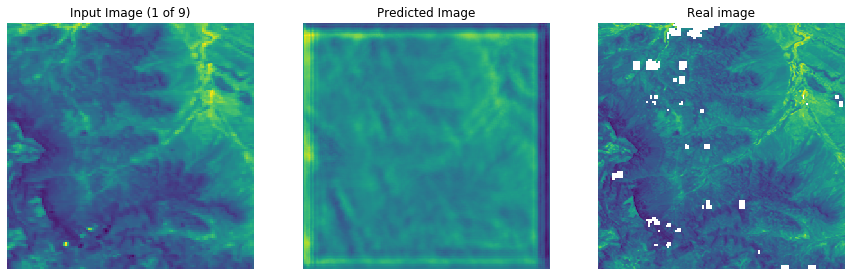

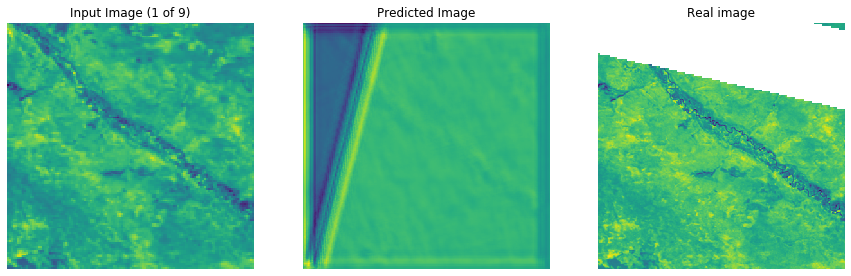

In [8]:
for lrs, hr in train_dataset.take(2):
    show_pred(model, lrs, hr)

In [9]:
EPOCHS = 5000
optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [10]:
checkpoint_dir = './TrainingCheckpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 model=model)

In [11]:
losses_record = []

def train(train_dataset, dev_dataset, optimizer, epochs):
    for epoch in range(epochs):
        start = time.time()
            
        loss = 0
        for lrs, hr in dev_dataset:
            loss += compute_loss(lrs, hr, model)

        losses_record.append(loss)
        
        for lrs, hr in train_dataset:
            train_step(lrs, hr, model, optimizer)
        
        # saving (checkpoint) the model every 100 epochs
        if (epoch + 1) % 100 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
        if (epoch + 1) % 20 == 0:
            for lrs, hr in dev_dataset.take(1):
                print("Showing current result")
                show_pred(model, lrs, hr)

        if (epoch + 1) % 1 == 0:
            print('Time taken for epoch {} is {} sec\n'.format(epoch + 1, time.time()-start))
            print('current val losses: ' + str(loss))
            print('=============================================')

In [12]:
train(train_dataset, dev_dataset, optimizer, 1000)

W0711 21:30:38.524925 140281844754240 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Time taken for epoch 1 is 251.1939492225647 sec

current val losses: tf.Tensor(0.14927524, shape=(), dtype=float32)
Time taken for epoch 2 is 240.1622552871704 sec

current val losses: tf.Tensor(0.0027765122, shape=(), dtype=float32)
Time taken for epoch 3 is 241.1541359424591 sec

current val losses: tf.Tensor(0.00264779, shape=(), dtype=float32)
Time taken for epoch 4 is 240.54032945632935 sec

current val losses: tf.Tensor(0.0023901325, shape=(), dtype=float32)
Time taken for epoch 5 is 237.80081844329834 sec

current val losses: tf.Tensor(0.8711262, shape=(), dtype=float32)
Time taken for epoch 6 is 229.0990822315216 sec

current val losses: tf.Tensor(0.0087973885, shape=(), dtype=float32)
Time taken for epoch 7 is 234.99924159049988 sec

current val losses: tf.Tensor(0.008790662, shape=(), dtype=float32)
Time taken for epoch 8 is 237.72066164016724 sec

current val losses: tf.Tensor(0.008791614, shape=(), dtype=float32)
Time taken for epoch 9 is 238.0956346988678 sec

current val 

KeyboardInterrupt: 

Showing current result


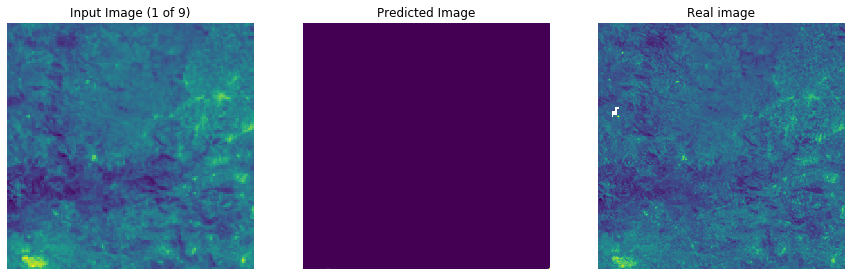

In [14]:
for lrs, hr in dev_dataset.take(1):
    print("Showing current result")
    show_pred(model, lrs, hr)